# Getting Shapes

## Setup

In [ ]:
!pip install selenium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.7/512.7 kB 12.2 MB/s eta 0:00:00


In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By

import os
import time
import zipfile
import shutil

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import random

## Make Directories

In [ ]:
shape_files_directory = os.path.abspath("/content/shape_files_download")
os.makedirs(shape_files_directory, exist_ok=True)

unzip_directory = os.path.abspath("/content/shape_files_unzip")
os.makedirs(unzip_directory, exist_ok=True)

## Download Shapefiles

In [ ]:
def create_browser_settings(output_dir):
    chrome_options = Options()

    chrome_options.add_argument("--headless")
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("--disable-dev-shm-usage")
    chrome_options.add_argument(
        "--user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36"
    )

    # Browser Download Preferences
    prefs = {
        "download.default_directory": os.path.abspath(output_dir),
        "download.prompt_for_download": False,
        "download.directory_upgrade": True,
    }
    chrome_options.add_experimental_option("prefs", prefs)

    return chrome_options

In [ ]:
def download(url, link_text, download_dir, pause_between_downloads=0.25):
    driver = webdriver.Chrome(options=create_browser_settings(download_dir))
    driver.get(url)

    # Find all shape file links
    links = driver.find_elements(By.TAG_NAME, "a")
    links = [link for link in links if link.get_attribute("href") and link_text in link.get_attribute("href")]

    # Iterate through all links and download
    for link in links:
        print(f"Fetching {link.get_attribute('href')}")

        try:
            driver.get(link.get_attribute("href"))
            time.sleep(pause_between_downloads)
        except Exception as e:
            print(f"Could not click link: {link.get_attribute('href')} - {e}")

    driver.quit()

In [ ]:
def unzip(input_dir, output_dir):
    zipped_shape_files = os.listdir(input_dir)

    for zipped_shape_file in zipped_shape_files:
        zip_file_path = os.path.join(input_dir, zipped_shape_file)
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(output_dir)

In [ ]:
download(
    url="https://sos.iowa.gov/shapefiles-city-precincts",
    link_text="elections/pdf/shapefiles",
    download_dir=shape_files_directory,
)

Fetching https://sos.iowa.gov/elections/pdf/shapefiles/City%20Precincts/Adel%20Precinct%20Boundaries.zip
Fetching https://sos.iowa.gov/elections/pdf/shapefiles/City%20Precincts/Albia%20Precincts%20Boundaries.zip
Fetching https://sos.iowa.gov/elections/pdf/shapefiles/City%20Precincts/Algona%20Precinct%20Boundaries.zip
Fetching https://sos.iowa.gov/elections/pdf/shapefiles/City%20Precincts/Altoona%20Precinct%20Boundaries.zip
Fetching https://sos.iowa.gov/elections/pdf/shapefiles/City%20Precincts/Ames%20Precinct%20Boundaries.zip
Fetching https://sos.iowa.gov/elections/pdf/shapefiles/City%20Precincts/Anamosa%20Precinct%20Boundaries.zip
Fetching https://sos.iowa.gov/elections/pdf/shapefiles/City%20Precincts/Ankeny%20Precinct%20Boundaries.zip
Fetching https://sos.iowa.gov/elections/pdf/shapefiles/City%20Precincts/Asbury%20Precinct%20Boundaries.zip
Fetching https://sos.iowa.gov/elections/pdf/shapefiles/City%20Precincts/Atlantic%20Precinct%20Boundaries.zip
Fetching https://sos.iowa.gov/electio

## Extract Shapefiles

In [ ]:
unzip(shape_files_directory, unzip_directory)

# Combining Shapefiles

## Standardize Each GDF

In [ ]:
TARGET_CRS = "EPSG:4326"

def standardize_gdfs(directory, exclude_wards=False, feedback=False, total_col=False):
    output_gdfs = []
    cols_to_keep = ["geometry"]
    unique_columns = set()

    if total_col:
        cols_to_keep.append("TOTAL")

    for file_path in os.listdir(directory):
        if not file_path.endswith(".shp"):
            continue

        # Skip Wards
        if "Ward" in file_path and exclude_wards:
            continue

        name = file_path.split(".shp")[0].replace("_", " ")

        # Load Shape File
        shape_file = gpd.read_file(os.path.join(directory, file_path))

        if total_col:
            shape_file = shape_file.rename(columns={'Population': 'TOTAL', 'DATA': 'TOTAL'})

            # if "TOTAL" not in shape_file.columns:
            #     continue

            print(shape_file.head())
            print(shape_file.columns)

        filtered_shape_file = shape_file[cols_to_keep]
        filtered_shape_file = filtered_shape_file.copy()
        filtered_shape_file["name"] = name

        # Standardize Coordinate System Used
        if filtered_shape_file.crs.to_string() != TARGET_CRS:
            filtered_shape_file = filtered_shape_file.to_crs(TARGET_CRS)

        for col in shape_file.columns:
            unique_columns.add(col)

        output_gdfs.append(filtered_shape_file)

    if feedback:
        print("Unique Columns: {")
        for col in list(unique_columns):
            print(f"    {col},")
        print("}")


    return output_gdfs

In [ ]:
standardized_gdfs = standardize_gdfs(unzip_directory, exclude_wards=False, feedback=False)

/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:198: RuntimeWarning: /content/shape_files_unzip/Carlisle_Precincts.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:198: RuntimeWarning: /content/shape_files_unzip/City_of_Ottumwa_Revised.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


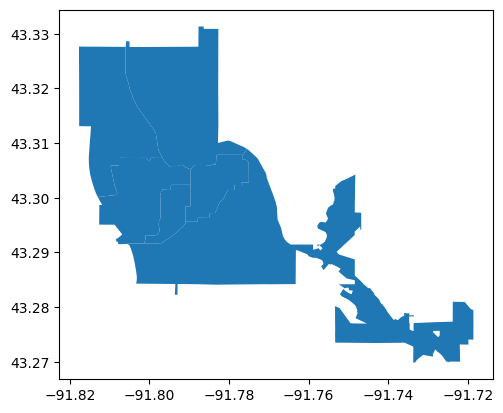

,geometry,name
0,"POLYGON ((-91.78591 43.29632, -91.78487 43.296...",Decorah Precincts - SOS REVISED
1,"POLYGON ((-91.78966 43.3014, -91.78966 43.3018...",Decorah Precincts - SOS REVISED
2,"POLYGON ((-91.78966 43.30236, -91.79091 43.302...",Decorah Precincts - SOS REVISED
3,"POLYGON ((-91.80877 43.3059, -91.80969 43.3058...",Decorah Precincts - SOS REVISED
4,"POLYGON ((-91.7972 43.30796, -91.79746 43.3083...",Decorah Precincts - SOS REVISED
5,"POLYGON ((-91.79723 43.29961, -91.79726 43.299...",Decorah Precincts - SOS REVISED


In [ ]:
random_plot = random.choice(standardized_gdfs)
random_plot.plot()
plt.show()
random_plot

## Combine All Shapes and Export Shapefile

In [ ]:
output_dir = os.path.abspath("/content/output")
os.makedirs(output_dir, exist_ok=True)

In [ ]:
combined_gdf = gpd.GeoDataFrame(
    pd.concat(standardized_gdfs, ignore_index=True),
    crs=TARGET_CRS
)
combined_gdf.to_file(os.path.join(output_dir, "output_file.shp"))

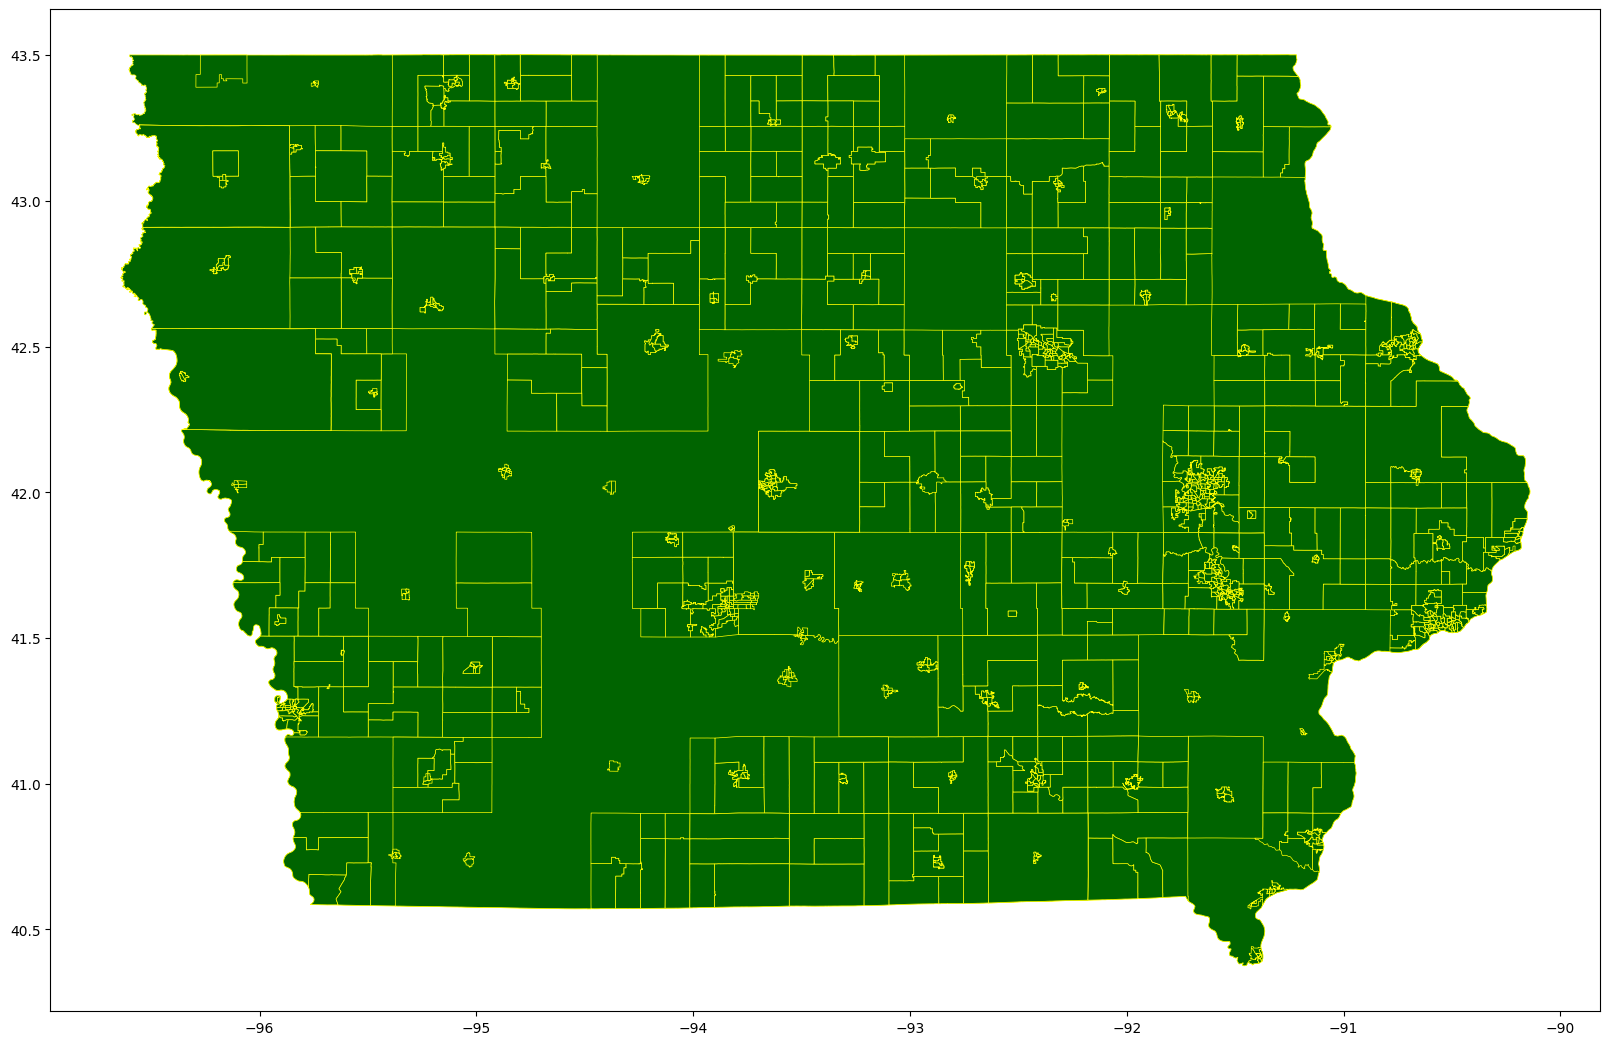

,geometry,name
0,"POLYGON ((-93.77922 42.47505, -93.77899 42.475...",Hamilton County Precincts - FINAL
1,"POLYGON ((-93.85023 42.44913, -93.85023 42.449...",Hamilton County Precincts - FINAL
2,"POLYGON ((-93.81309 42.42719, -93.81298 42.427...",Hamilton County Precincts - FINAL
3,"POLYGON ((-93.73801 42.38346, -93.73817 42.383...",Hamilton County Precincts - FINAL
4,"POLYGON ((-93.73517 42.47634, -93.73516 42.477...",Hamilton County Precincts - FINAL
...,...,...
2364,"POLYGON ((-93.09847 41.07428, -93.09847 41.074...",Reprecincting 2020 census
2365,"POLYGON ((-93.27008 41.16074, -93.26993 41.160...",Reprecincting 2020 census
2366,"POLYGON ((-91.48223 43.26925, -91.48211 43.269...",WaukonCity
2367,"POLYGON ((-91.47353 43.29097, -91.47249 43.290...",WaukonCity


In [ ]:
fig, ax = plt.subplots(figsize=(20, 16))
combined_gdf.plot(
    ax=ax,
    edgecolor="yellow",   # color of the shape borders
    linewidth=0.5,        # thickness of shape borders
    facecolor="darkgreen" # color of Iowa
)
plt.show()
combined_gdf

# County Shapefiles

In [ ]:
county_shape_files_directory = os.path.abspath("/content/county_shape_files_download")
os.makedirs(county_shape_files_directory, exist_ok=True)

county_unzip_directory = os.path.abspath("/content/county_shape_files_unzip")
os.makedirs(county_unzip_directory, exist_ok=True)

In [ ]:
download(
    url="https://sos.iowa.gov/shapefiles-county-precincts",
    link_text="elections/pdf/shapefiles",
    download_dir=county_shape_files_directory,
)

Fetching https://sos.iowa.gov/elections/pdf/shapefiles/County%20Precincts/Adair%20County%20Precinct%20Boundaries.zip
Fetching https://sos.iowa.gov/elections/pdf/shapefiles/County%20Precincts/Adams%20County%20Precinct%20Boundaries.zip
Fetching https://sos.iowa.gov/elections/pdf/shapefiles/County%20Precincts/Allamakee%20County%20Precinct%20Boundaries.zip
Fetching https://sos.iowa.gov/elections/pdf/shapefiles/County%20Precincts/Appanoose%20County%20Precinct%20Boundaries.zip
Fetching https://sos.iowa.gov/elections/pdf/shapefiles/County%20Precincts/Audubon%20County%20Precinct%20Boundaries.zip
Fetching https://sos.iowa.gov/elections/pdf/shapefiles/County%20Precincts/Benton%20County%20Precinct%20Boundaries.zip
Fetching https://sos.iowa.gov/elections/pdf/shapefiles/County%20Precincts/Black%20Hawk%20County%20Precinct%20Boundaries.zip
Fetching https://sos.iowa.gov/elections/pdf/shapefiles/County%20Precincts/Boone%20County%20Precinct%20Boundaries.zip
Fetching https://sos.iowa.gov/elections/pdf/sh

In [ ]:
unzip(county_shape_files_directory, county_unzip_directory)

In [ ]:
standardized_gdfs = standardize_gdfs(county_unzip_directory, exclude_wards=False, feedback=False, total_col=True)

     LONGNAME SHORTNAME  DISTRICT       COLOR  TOTAL  TARGET_DEV  \
0  District 1        D1         1  1288812928   2595         447   
1  District 2        D2         2  1613326976   2823         675   
2  District 3        D3         3  -133888217   2447         299   
3  District 4        D4         4  1064566656   1136       -1012   
4  District 5        D5         5   566969984   1051       -1097   

                                            geometry  
0  POLYGON ((-93.77922 42.47505, -93.77899 42.475...  
1  POLYGON ((-93.85023 42.44913, -93.85023 42.449...  
2  POLYGON ((-93.81309 42.42719, -93.81298 42.427...  
3  POLYGON ((-93.73801 42.38346, -93.73817 42.383...  
4  POLYGON ((-93.73517 42.47634, -93.73516 42.477...  
Index(['LONGNAME', 'SHORTNAME', 'DISTRICT', 'COLOR', 'TOTAL', 'TARGET_DEV',
       'geometry'],
      dtype='object')
     LONGNAME SHORTNAME  DISTRICT      COLOR  TOTAL  TARGET_DEV  \
0  Precinct 1        P1         1 -146538483   1039        -651   
1  Precin

In [ ]:
output_dir = os.path.abspath("/content/output_county")
os.makedirs(output_dir, exist_ok=True)

In [ ]:
combined_gdf = gpd.GeoDataFrame(
    pd.concat(standardized_gdfs, ignore_index=True),
    crs=TARGET_CRS
)
combined_gdf.to_file(os.path.join(output_dir, "output_file.shp"))

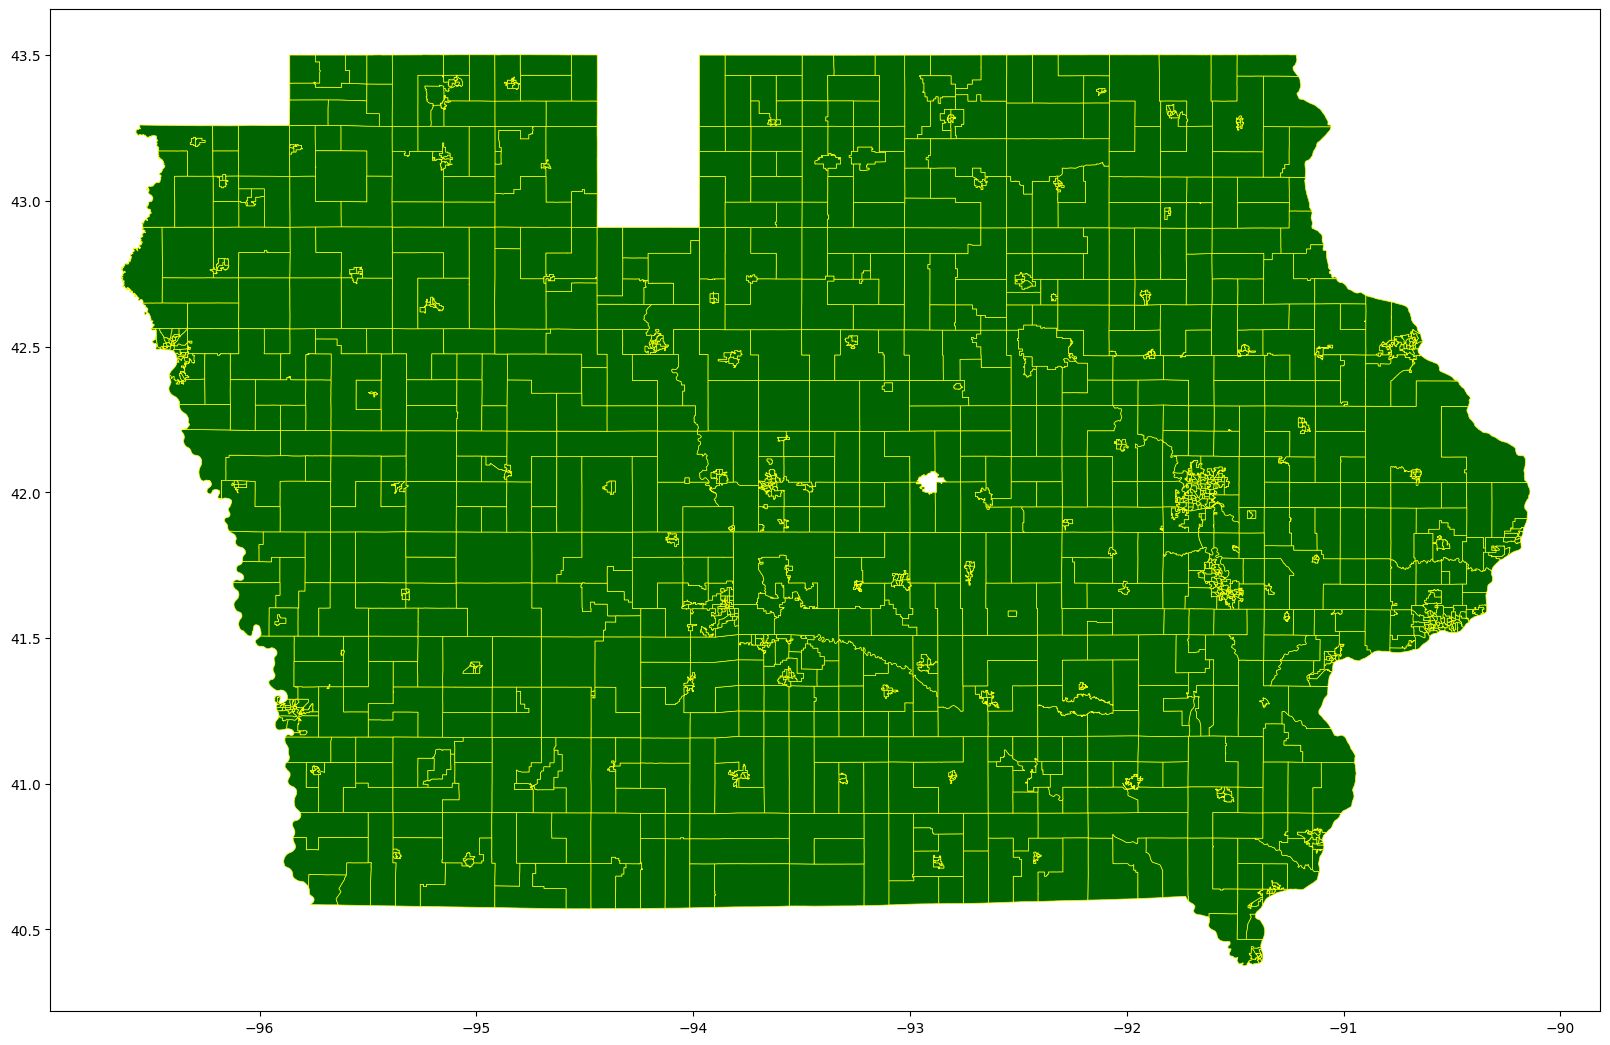

,geometry,TOTAL,name
0,"POLYGON ((-93.77922 42.47505, -93.77899 42.475...",2595.0,Hamilton County Precincts - FINAL
1,"POLYGON ((-93.85023 42.44913, -93.85023 42.449...",2823.0,Hamilton County Precincts - FINAL
2,"POLYGON ((-93.81309 42.42719, -93.81298 42.427...",2447.0,Hamilton County Precincts - FINAL
3,"POLYGON ((-93.73801 42.38346, -93.73817 42.383...",1136.0,Hamilton County Precincts - FINAL
4,"POLYGON ((-93.73517 42.47634, -93.73516 42.477...",1051.0,Hamilton County Precincts - FINAL
...,...,...,...
1365,"POLYGON ((-93.32772 41.02628, -93.32772 41.026...",727.0,Reprecincting 2020 census
1366,"POLYGON ((-93.44222 40.99681, -93.44214 40.987...",914.0,Reprecincting 2020 census
1367,"POLYGON ((-93.31741 40.89793, -93.32007 40.897...",887.0,Reprecincting 2020 census
1368,"POLYGON ((-93.09847 41.07428, -93.09847 41.074...",906.0,Reprecincting 2020 census


In [ ]:
fig, ax = plt.subplots(figsize=(20, 16))
combined_gdf.plot(
    ax=ax,
    edgecolor="yellow",   # color of the shape borders
    linewidth=0.5,        # thickness of shape borders
    facecolor="darkgreen" # color of Iowa
)
plt.show()
combined_gdf

In [ ]:
count = 0

for file in os.listdir(shape_files_directory):
    if file.endswith(".zip"):
        count += 1
        print(file)

print(f"Total Counties: {count}")

Carlisle Precinct Boundaries.zip
Wapello County Precinct Boundaries.zip
Mills County Precinct Boundaries.zip
Monticello Precinct Boundaries.zip
Adams County Precinct Boundaries.zip
Atlantic Precinct Boundaries.zip
Rock Valley Precinct Boundaries.zip
Bondurant Precinct Boundaries.zip
Clear Lake Precinct Boundaries.zip
Windsor Heights Precinct Boundaries.zip
Harlan Ward Boundaries.zip
Coralville Precinct Boundaries.zip
Glenwood Precinct Boundaries.zip
Mount Vernon Precinct Boundaries.zip
Wright County Precinct Boundaries.zip
Clive Precinct Boundaries.zip
Fort Madison Precinct Boundaries.zip
Webster County Precinct Boundaries.zip
Independence Precinct Boundaries.zip
Washinton Precinct Boundaries.zip
Algona Precinct Boundaries.zip
Adel Precinct Boundaries.zip
Bettendorf Precinct Boundaries.zip
Altoona Precinct Boundaries.zip
Dubuque Ward Boundaries.zip
Corning Precinct Boundaries.zip
Union County Precinct Boundaries.zip
Johnson County Precinct Boundaries.zip
Linn County Precinct Boundaries